# Lag Features Are All You Need

> **Credits:** Based on [this](https://www.kaggle.com/code/ragnar123/amex-lgbm-dart-cv-0-7963) amazing notebook.

OK. Maybe not **all** you need.
<br>
But they improve `LightGBM`!
_____


This notebook stated as an ensemble of `LightGBM` + `Catboost` + `XGB` but while running it I discovered an interestin idea that worked really well.

### Lag Features

On this competition we get information about clients of AMEX over time. 
Most high scoring notebooks on this competiion focused on aggregating the information per client and create a single row of extracted features: One for each client.

**One of such agg function is `last`**.

Quick examination revealed that the `last` feature is extreamly powerful at predicting if the client defaults or not (well.. make sense..). 
So I took this two steps further: 

- **First feature:** Just like the `last` feature: I added a `first` feature. 
- **"Lag" fearures:** to capture the change over time about each client I calculated two features for every `first`, `last` pair:
     - **Last - First:** The change since we first see the client to the last time we see the client.
     - **Last / First:** The fractional difference since we first see the client to the last time we see the client.

This improved my `LightGBM` model to the point that it overtook the whole `LightGBM` + `Catboost` + `XGB` ensemble.

I uploaded a dataset containing the extracted lag features and updated the final model predictions (only `LightGBM` this time) for everyone to play with. 

<br>

_____

**Next Experiement (currently running):** More "lag features" variations - Also take in consideration other indices of the time-series. will keep you updated.
_____

<br>





# Preparing for colab

In [1]:
!pip install catboost
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [3]:
!kaggle competitions download -c amex-default-prediction -f sample_submission.csv
!unzip /content/sample_submission.csv.zip

 37% 12.0M/32.4M [00:00<00:00, 125MB/s]
100% 32.4M/32.4M [00:00<00:00, 194MB/s]
Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [4]:
!kaggle competitions download -c amex-default-prediction -f train_labels.csv
!unzip /content/train_labels.csv.zip

 99% 16.0M/16.2M [00:00<00:00, 167MB/s]
100% 16.2M/16.2M [00:00<00:00, 167MB/s]
Archive:  /content/train_labels.csv.zip
  inflating: train_labels.csv        


In [5]:
!kaggle datasets download -d raddar/amex-data-integer-dtypes-parquet-format
!unzip /content/amex-data-integer-dtypes-parquet-format.zip

100% 4.06G/4.07G [00:22<00:00, 188MB/s]
100% 4.07G/4.07G [00:22<00:00, 193MB/s]
Archive:  /content/amex-data-integer-dtypes-parquet-format.zip
  inflating: test.parquet            
  inflating: train.parquet           


# Preprocessing

In [6]:
# ====================================================
# Library
# ====================================================
import gc
import warnings
warnings.filterwarnings('ignore')
import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
import itertools

# ====================================================
# Read & preprocess data and save it to disk
# ====================================================
def read_preprocess_data():
    train = pd.read_parquet('/content/train.parquet')
    features = train.drop(['customer_ID', 'S_2'], axis = 1).columns.to_list()
    cat_features = [
        "B_30",
        "B_38",
        "D_114",
        "D_116",
        "D_117",
        "D_120",
        "D_126",
        "D_63",
        "D_64",
        "D_66",
        "D_68",
    ]
    num_features = [col for col in features if col not in cat_features]
    
    # Train FE
    print('Starting train feature extraction')
    train_num_agg = train.groupby("customer_ID")[num_features].agg(['first', 'mean', 'std', 'min', 'max', 'last'])
    train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
    train_num_agg.reset_index(inplace = True)

    # Lag Features
    for col in train_num_agg:
        if 'last' in col and col.replace('last', 'first') in train_num_agg:
            train_num_agg[col + '_lag_sub'] = train_num_agg[col] - train_num_agg[col.replace('last', 'first')]
#             train_num_agg[col + '_lag_div'] = train_num_agg[col] / train_num_agg[col.replace('last', 'first')]

#     train_cat_agg = train.groupby("customer_ID")[cat_features].agg(['count', 'first', 'last', 'nunique'])
    train_cat_agg = train.groupby("customer_ID")[cat_features].agg(['first', 'last'])
    train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
    train_cat_agg.reset_index(inplace = True)
    
    train_labels = pd.read_csv('/content/train_labels.csv')
    train = train_num_agg.merge(train_cat_agg, how = 'inner', on = 'customer_ID').merge(train_labels, how = 'inner', on = 'customer_ID')
    print('Train shape: ', train.shape)    
    del train_num_agg, train_cat_agg
    gc.collect()
    
    train.to_parquet('train_fe_plus_plus.parquet')
    del train
    gc.collect()
    
    # Test FE
    test = pd.read_parquet('/content/test.parquet')
    print('Starting test feature extraction')
    test_num_agg = test.groupby("customer_ID")[num_features].agg(['first', 'mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
    test_num_agg.reset_index(inplace = True)

    # Lag Features
    for col in test_num_agg:
        if 'last' in col and col.replace('last', 'first') in test_num_agg:
            test_num_agg[col + '_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', 'first')]
#             test_num_agg[col + '_lag_div'] = test_num_agg[col] / test_num_agg[col.replace('last', 'first')]

#     test_cat_agg = test.groupby("customer_ID")[cat_features].agg(['count', 'first', 'last', 'nunique'])
    test_cat_agg = test.groupby("customer_ID")[cat_features].agg(['first', 'last'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
    test_cat_agg.reset_index(inplace = True)
    
    test = test_num_agg.merge(test_cat_agg, how = 'inner', on = 'customer_ID')
    print('Test shape: ', test.shape)
    del test_num_agg, test_cat_agg
    gc.collect()
    
    
    # Save files to disk
    test.to_parquet('test_fe_plus_plus.parquet')
    del test
    gc.collect()
    
# Read & Preprocess Data
# read_preprocess_data()

In [7]:
# !mv /content/train_fe_plus_plus.parquet /content/amex-fe-plus/
# !mv /content/test_fe_plus_plus.parquet /content/amex-fe-plus/

In [8]:
# !kaggle datasets init -p /content/amex-fe-plus

In [9]:
# !mv /content/dataset-metadata.json /content/amex-fe-plus/

In [10]:
# !kaggle datasets create -p /content/amex-fe-plus

# Training & Inference

In [11]:
!kaggle datasets download -d ryuina/amex-fe-plus
!unzip /content/amex-fe-plus.zip

100% 3.41G/3.42G [00:13<00:00, 296MB/s]
100% 3.42G/3.42G [00:13<00:00, 270MB/s]
Archive:  /content/amex-fe-plus.zip
  inflating: test_fe_plus_plus.parquet  
  inflating: train_fe_plus_plus.parquet  


In [14]:
# ====================================================
# Library
# ====================================================
import os
import gc; gc.enable()
import joblib
import pickle
import random
import warnings
import itertools
import scipy as sp
import numpy as np
import pandas as pd
from tqdm import tqdm
import xgboost as xgb
import lightgbm as lgb
warnings.filterwarnings('ignore')
from itertools import combinations
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
from catboost import CatBoostClassifier
pd.set_option('display.max_columns', 500)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split

class CFG:
    input_dir = '/content/'
    seed = 42
    n_folds = 5
    target = 'target'

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

def read_data():
    train = pd.read_parquet(CFG.input_dir + 'train_fe_plus_plus.parquet')
    test = pd.read_parquet(CFG.input_dir + 'test_fe_plus_plus.parquet')
    return train, test

def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

def amex_metric_np(preds, target):
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / np.sum(target)
    weighted_target = target * weight
    lorentz = (weighted_target / weighted_target.sum()).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()
    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)
    g = gini / gini_max
    return 0.5 * (g + d)

### Training LightGBM (DART) Model

- Final predictions output uploaded as a public dataset. 

In [15]:
seed_everything(CFG.seed)
train, test = read_data()

In [16]:
# Label encode categorical features
cat_features = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_66",
    "D_68"
]
cat_features = [f"{cf}_last" for cf in cat_features]
for cat_col in cat_features:
    encoder = LabelEncoder()
    train[cat_col] = encoder.fit_transform(train[cat_col])
    test[cat_col] = encoder.transform(test[cat_col])

# Round last float features to 2 decimal place
num_cols = list(train.dtypes[(train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
num_cols = [col for col in num_cols if 'last' in col]
for col in num_cols:
    train[col + '_round2'] = train[col].round(2)
    test[col + '_round2'] = test[col].round(2)

# Get feature list
features = [col for col in train.columns if col not in ['customer_ID', CFG.target]]

In [17]:
params = {
    'objective': 'binary',
    'metric': "binary_logloss",
    'boosting': 'dart',
    'seed': CFG.seed,
    'num_leaves': 100,
    'learning_rate': 0.02,
    'feature_fraction': 0.20,
    'bagging_freq': 10,
    'bagging_fraction': 0.50,
    'n_jobs': -1,
    'lambda_l2': 2,
    'min_data_in_leaf': 40
    }

In [ ]:
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True

def train_and_evaluate(train):
    # Create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))
    kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train, train[CFG.target])):
        print(' ')
        print('-'*50)
        print(f'Training fold {fold} with {len(features)} features...')
        x_train, x_val = train[features].iloc[trn_ind], train[features].iloc[val_ind]
        y_train, y_val = train[CFG.target].iloc[trn_ind], train[CFG.target].iloc[val_ind]
        lgb_train = lgb.Dataset(x_train, y_train, categorical_feature = cat_features)
        lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature = cat_features)
        model = lgb.train(
            params = params,
            train_set = lgb_train,
            num_boost_round = 10500,
            valid_sets = [lgb_train, lgb_valid],
            early_stopping_rounds = 100,
            verbose_eval = 500,
            feval = lgb_amex_metric
            )
        # Save best model
        joblib.dump(model, f'lgbm_fold{fold}_seed{CFG.seed}.pkl')
        # Predict validation
        val_pred = model.predict(x_val)
        # Add to out of folds array
        oof_predictions[val_ind] = val_pred

        # Compute fold metric
        score = amex_metric(y_val, val_pred)
        print(f'Our fold {fold} CV score is {score}')
        del x_train, x_val, y_train, y_val, lgb_train, lgb_valid, model
        gc.collect()
    # Compute out of folds metric
    score = amex_metric(train[CFG.target], oof_predictions)
    print(f'Our out of folds CV score is {score}')
    # Create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({'customer_ID': train['customer_ID'], 'target': train[CFG.target], 'prediction': oof_predictions})
    oof_df.to_csv(f'oof_lgbm_baseline_{CFG.n_folds}fold_seed{CFG.seed}.csv', index = False)

train_and_evaluate(train)

 
--------------------------------------------------
Training fold 0 with 1447 features...
[500]	training's binary_logloss: 0.257983	training's amex_metric: 0.789465	valid_1's binary_logloss: 0.262221	valid_1's amex_metric: 0.778262
[1000]	training's binary_logloss: 0.21133	training's amex_metric: 0.81624	valid_1's binary_logloss: 0.223763	valid_1's amex_metric: 0.791409


In [ ]:
del train
_ = gc.collect()

# Test part

In [ ]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

In [ ]:
# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 4

customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

In [ ]:
# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []

for k in range(NUM_PARTS):
    
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test_copy = test.iloc[skip_rows:skip_rows+rows[k]].copy()
    test_copy = test_copy.set_index('customer_ID')
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test_copy.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    if k==NUM_PARTS-1: test_copy = test_copy.loc[customers[skip_cust:]]
    else: test_copy = test_copy.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
        
    # INFER XGB MODELS ON TEST DATA
    model = joblib.load(f'lgbm_fold0_seed{CFG.seed}.pkl')
    preds = model.predict_proba(test_copy)[:, 1]
    for f in range(1,fold):
        model = joblib.load(f'lgbm_fold{fold}_seed{CFG.seed}.pkl')
        preds += model.predict_proba(test_copy)[:, 1]
    preds /= fold
    test_preds.append(preds)

    # CLEAN MEMORY
    del test_copy, model
    _ = gc.collect()

del test
_ = gc.collect()


Reading test data...
=> Test part 1 has shape (231155, 1261)

Reading test data...
=> Test part 2 has shape (231155, 1261)

Reading test data...
=> Test part 3 has shape (231155, 1261)

Reading test data...
=> Test part 4 has shape (231156, 1261)


# Submit

In [ ]:
# WRITE SUBMISSION FILE
test_preds = np.concatenate(test_preds)
test = pd.DataFrame(index=customers,data={'prediction':test_preds})
sub = pd.read_csv(parent_dir + 'sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].copy()
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

# DISPLAY PREDICTIONS
sub.to_csv(f'submission_cat_v{VER}_seed{SEED}_fold{fold}.csv',index=False)
print('Submission file shape is', sub.shape )
sub.head()

Submission file shape is (924621, 2)


,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.018191
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.001287
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.047585
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.179673
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.854425


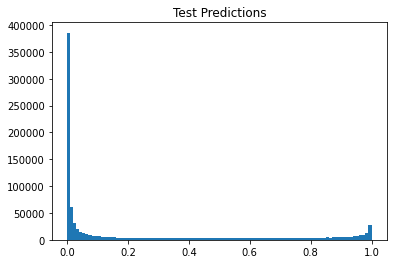

In [ ]:
# PLOT PREDICTIONS
plt.hist(sub.prediction, bins=100)
plt.title('Test Predictions')
plt.show()

# Prediction

- Replace / comment-out this to use your own predictions from the model in the above cell.

In [ ]:
# Submit
!kaggle competitions submit -c amex-default-prediction -f submission_lgbm_v1_seed42_fold5.csv -m "From colab"

In [ ]:
import os
import pandas as pd

df_1 = pd.read_csv('/content/amex-predictions/test_lgbm_baseline_5fold_seed42.csv')
df_1.to_csv('submission.csv', index=False)